# Greedy descent as a post-processing

## Problem instance

In [47]:
import random
import dimod


N = 100
h = {}
J = {(i, j): random.gauss(0, 1) for i in range(N) for j in range(i + 1, N)}

bqm = dimod.BinaryQuadraticModel.from_ising(h, J)

## Embed & Post to D-Wave solver

In [49]:
from dwave.system import DWaveSampler
from dwave.embedding import embed_bqm
from minorminer import find_embedding
from minorminer.busclique import find_clique_embedding

dw_sampler = DWaveSampler(profile='sigu-adv')

In [50]:
adj = {k: 1 for k in bqm.quadratic.keys()}
%time embedding = find_clique_embedding(g=dw_sampler.to_networkx_graph(), nodes=N, use_cache=True)
%time bqm_embed = embed_bqm(bqm, embedding, dw_sampler.adjacency)

# adj = {k: 1 for k in bqm.quadratic.keys()}
# %time embedding = find_embedding(adj, dw_sampler.edgelist, random_seed=1, threads=4)
# %time bqm_embed = embed_bqm(bqm, embedding, dw_sampler.adjacency)

CPU times: user 226 ms, sys: 16.2 ms, total: 243 ms
Wall time: 252 ms
CPU times: user 79 ms, sys: 632 µs, total: 79.6 ms
Wall time: 79.5 ms


In [51]:
%%time
raw_sampleset = dw_sampler.sample(bqm_embed, num_reads=1000)

CPU times: user 50.1 ms, sys: 860 µs, total: 50.9 ms
Wall time: 50.4 ms


## Chain-break resolution

In [52]:
from dwave.embedding import unembed_sampleset
from dwave.embedding import majority_vote, weighted_random, discard, MinimizeEnergy

minimize_energy = MinimizeEnergy(bqm, embedding)

In [57]:
%time sampleset_mj = unembed_sampleset(raw_sampleset, embedding, bqm, chain_break_method=majority_vote)
%time sampleset_wr = unembed_sampleset(raw_sampleset, embedding, bqm, chain_break_method=weighted_random)
%time sampleset_dc = unembed_sampleset(raw_sampleset, embedding, bqm, chain_break_method=discard)
%time sampleset_me = unembed_sampleset(raw_sampleset, embedding, bqm, chain_break_method=minimize_energy)

CPU times: user 73 ms, sys: 23.3 ms, total: 96.3 ms
Wall time: 47.4 ms
CPU times: user 115 ms, sys: 24.4 ms, total: 139 ms
Wall time: 36.5 ms
CPU times: user 68.9 ms, sys: 11.8 ms, total: 80.7 ms
Wall time: 20.9 ms
CPU times: user 4.73 s, sys: 70.8 ms, total: 4.8 s
Wall time: 4.53 s


## Greedy descent

In [56]:
from greedy import SteepestDescentSolver

greedy_sampler = SteepestDescentSolver()

In [58]:
sampleset_mj_greedy = greedy_sampler.sample(bqm, num_reads=1000, initial_states=sampleset_mj.record.sample, seed=1)
sampleset_wr_greedy = greedy_sampler.sample(bqm, num_reads=1000, initial_states=sampleset_wr.record.sample, seed=1)
sampleset_dc_greedy = greedy_sampler.sample(bqm, num_reads=1000, initial_states=sampleset_dc.record.sample, seed=1)
sampleset_me_greedy = greedy_sampler.sample(bqm, num_reads=1000, initial_states=sampleset_me.record.sample, seed=1)

sampleset_rand_init = greedy_sampler.sample(bqm, num_reads=1000, initial_states_generator='random', seed=1)

## Results

In [59]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['figure.facecolor'] = 'w'

plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['mathtext.cal'] = 'serif'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'cm'

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = 1.0

plt.rcParams['legend.loc'] = 'best'
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.fancybox'] = False

plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.linewidth'] = 1.0

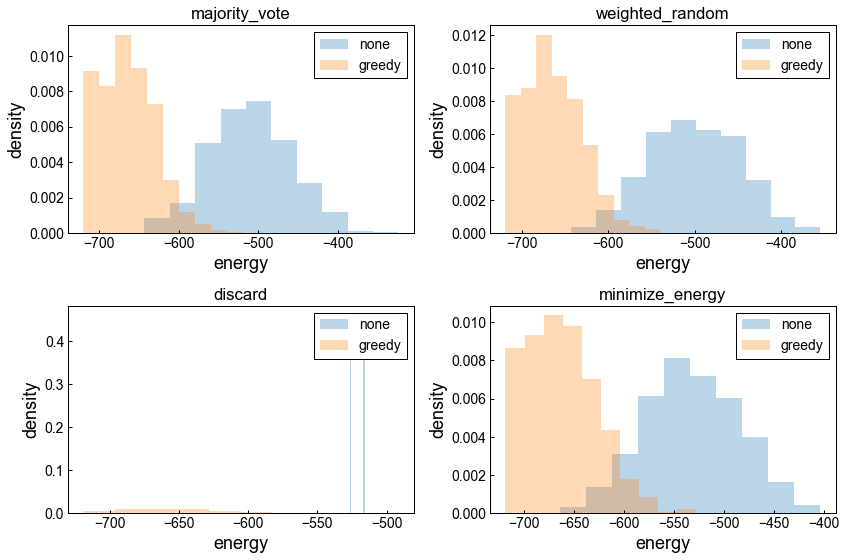

In [61]:
fig = plt.figure(figsize=(12, 8))
axes = fig.subplots(nrows=2, ncols=2)

axes[0][0].hist(sampleset_mj.record.energy, density=True, alpha=0.3, label='none')
axes[0][0].hist(sampleset_mj_greedy.record.energy, density=True, alpha=0.3, label='greedy')
axes[0][0].set_title('majority_vote')
axes[0][0].set_xlabel('energy')
axes[0][0].set_ylabel('density')
axes[0][0].legend(loc='upper right')

axes[0][1].hist(sampleset_wr.record.energy, density=True, alpha=0.3, label='none')
axes[0][1].hist(sampleset_wr_greedy.record.energy, density=True, alpha=0.3, label='greedy')
axes[0][1].set_title('weighted_random')
axes[0][1].set_xlabel('energy')
axes[0][1].set_ylabel('density')
axes[0][1].legend(loc='upper right')

axes[1][0].hist(sampleset_dc.record.energy, density=True, alpha=0.3, label='none')
axes[1][0].hist(sampleset_dc_greedy.record.energy, density=True, alpha=0.3, label='greedy')
axes[1][0].set_title('discard')
axes[1][0].set_xlabel('energy')
axes[1][0].set_ylabel('density')
axes[1][0].legend(loc='upper right')

axes[1][1].hist(sampleset_me.record.energy, density=True, alpha=0.3, label='none')
axes[1][1].hist(sampleset_me_greedy.record.energy, density=True, alpha=0.3, label='greedy')
axes[1][1].set_title('minimize_energy')
axes[1][1].set_xlabel('energy')
axes[1][1].set_ylabel('density')
axes[1][1].legend(loc='upper right')

plt.tight_layout()
plt.show()

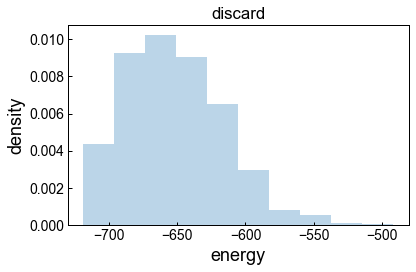

In [62]:
plt.hist(sampleset_rand_init.record.energy, density=True, alpha=0.3)
plt.title('discard')
plt.xlabel('energy')
plt.ylabel('density')
plt.tight_layout()
plt.show()

In [63]:
import pandas as pd


sampleset_list = [sampleset_mj, sampleset_wr, sampleset_dc, sampleset_me,
                  sampleset_mj_greedy, sampleset_wr_greedy, sampleset_dc_greedy, sampleset_me_greedy,
                  sampleset_rand_init]

aggregations = []
for samp in sampleset_list:
    energy = samp.record.energy
    aggregations.append([np.min(energy), np.mean(energy), np.max(energy), np.std(energy), np.sum(samp.record.num_occurrences)])

index = ['majority_vote', 'weighted_random', 'discard', 'minimize_energy',
         'majority_vote(greegy)', 'weighted_random(greegy)', 'discard(greegy)', 'minimize_energy(greegy)',
         'random init states(greedy)']
columns = ['energy(min)', 'energy(mean)', 'energy(max)', 'energy(std)', 'num_occurrences']
df_aggr = pd.DataFrame(aggregations, index=index, columns=columns)
df_aggr

,energy(min),energy(mean),energy(max),energy(std),num_occurrences
majority_vote,-642.618362,-509.955511,-324.870500,50.847352,1000
weighted_random,-642.618362,-500.773185,-354.848499,51.451491,1000
discard,-526.492295,-521.051695,-515.611096,5.440600,2
minimize_energy,-664.536202,-531.262475,-403.476015,46.995649,1000
majority_vote(greegy),-718.968897,-663.864370,-519.651562,34.613129,1000
weighted_random(greegy),-718.968897,-663.951955,-540.121615,33.542041,1000
discard(greegy),-718.968897,-652.018753,-491.522041,36.380169,1000
minimize_energy(greegy),-718.968897,-662.864103,-527.712127,34.761184,1000
random init states(greedy),-718.968897,-652.001881,-491.522041,36.427022,1000


## Supplement

In [14]:
from greedy import SteepestDescentSampler

SteepestDescentSampler == SteepestDescentSolver

True

In [ ]:
from dwave.system import EmbeddingComposite
from greedy import SteepestDescentComposite

ec_sampler = EmbeddingComposite(dw_sampler, find_embedding=find_embedding,
                                embedding_parameters=dict(random_seed=1, threads=4))
greedy_sampler = SteepestDescentComposite(ec_sampler)

# sampleset = greedy_sampler.sample(bqm, num_reads=100)

In [64]:
from dwave.embedding.pegasus import find_clique_embedding, pegasus_graph

adj = {k: 1 for k in bqm.quadratic.keys()}
# %time embedding = find_clique_embedding(k=10, target_graph=dw_sampler.to_networkx_graph())
# %time embedding = find_clique_embedding(k=10, target_graph=pegasus.pegasus_graph(m=2))
%time embedding = find_clique_embedding(k=10, m=2)
%time bqm_embed = embed_bqm(bqm, embedding, dw_sampler.adjacency)

CPU times: user 29.1 ms, sys: 485 µs, total: 29.6 ms
Wall time: 29.6 ms


DisconnectedChainError: chain for 0 is not connected

In [74]:
from dwave.system import DWaveCliqueSampler

dw_clique_sampler = DWaveCliqueSampler(profile='sigu-adv')

In [75]:
sampleset = dw_clique_sampler.sample(bqm, num_reads=1000)

In [77]:
print(dw_clique_sampler.parameters)

{'anneal_offsets': ['parameters'], 'anneal_schedule': ['parameters'], 'annealing_time': ['parameters'], 'answer_mode': ['parameters'], 'flux_biases': ['parameters'], 'flux_drift_compensation': ['parameters'], 'h_gain_schedule': ['parameters'], 'initial_state': ['parameters'], 'max_answers': ['parameters'], 'num_reads': ['parameters'], 'num_spin_reversal_transforms': ['parameters'], 'programming_thermalization': ['parameters'], 'readout_thermalization': ['parameters'], 'reduce_intersample_correlation': ['parameters'], 'reinitialize_state': ['parameters'], 'warnings': []}


In [79]:
dw_clique_sampler.largest_clique_size

120